## Benchmark 4: Oneshot naive model cross validation
Major consideration here is, do we score one time point from the forecast period or all four? Thinking we should probably do both. Scoring one point will give us the best comparison to the current public leaderboard. But the actual model we need to build will be predicting four future timepoints.
1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Load & inspect](#load_inspect)
3. [Cross validation SMAPE](#cross_validation_smape)

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
import functions.data_manipulation_functions as data_funcs

import numpy as np
import pandas as pd
import multiprocessing as mp

print(f'Python: {sys.version}')
print()
print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Numpy 1.23.5
Pandas 1.4.3


<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

<a name="load_inspect"></a>
### 2. Load & inspect

In [2]:
# Load cross validation data
model_order = 4
forecast_horizon = 4

input_file = f'{conf.PARSED_DATA_PATH}/order{model_order}_horizon{forecast_horizon}.npy'
parsed_data = np.load(input_file)

print(f'Data type: {type(parsed_data)}')
print(f'Data shape: {parsed_data.shape}')

Data type: <class 'numpy.ndarray'>
Data shape: (100320, 2, 4, 4)


OK this, numpy array is structured as follows:
+ **First dimension**: data elements: overlapping blocks from each counties timeseries
+ **Second dimension**: input, forecast block halves
+ **Third dimension**: rows: timepoints
+ **Fourth dimension**: columns: *cfips, first_day_of_month, microbusiness_density, active*

Let's start by defining some helper functions so that we can easily loop over multiple samples, calculating training and validation scores for each.

<a name="cross_validation_SMAPE"></a>
### 3. Cross validation SMAPE

In [3]:
# Set number of folds and training-validation split
folds = 100
training_fraction = 0.7

In [4]:
%%time

# Generate, forecast and score folds training-validation splits
smape_scores_df = data_funcs.crossvalidation_smape(parsed_data, folds, training_fraction)

print()


CPU times: user 11min 44s, sys: 67.7 ms, total: 11min 44s
Wall time: 11min 45s


Thinking we should take the time to parallelize this on available CPUs over the folds. It's slow enough to make experimentation and optimization cumbersome. We could probably optimize the code a bit, but let's come back to that later after we are sure we are implementing the cross validation strategy we really want here.

In [5]:
%%time

# Fire up the pool
pool, result_objects = data_funcs.start_multiprocessing_pool()

# Submit each fold to a different CPU thread
for fold in range(folds):

    result = pool.apply_async(data_funcs.parallel_crossvalidation_smape,
    args = (
        parsed_data,
        training_fraction
        )
    )

    result_objects.append(result)

# Get results and shut down pool
smape_scores_df = data_funcs.cleanup_multiprocessing_pool(pool, result_objects)

print()

Starting processes for 18 CPUs (available - 2)

CPU times: user 2.42 s, sys: 1.92 s, total: 4.35 s
Wall time: 1min 6s


Wooo, parallelism! 5.5 minutes single threaded vs 0.5 minutes on 18 treads ~11x speed-up. Nice quality of life improvement. 

<a name="results"></a>
### 4. Results

In [6]:
smape_scores_df.head()

,one_point_training,one_point_validation,four_point_training,four_point_validation
0,1.774551,1.773205,3.087731,3.075329
1,1.776993,1.767508,3.073594,3.108315
2,1.775319,1.771414,3.100869,3.044672
3,1.759241,1.808929,3.064798,3.128838
4,1.772443,1.778123,3.093902,3.060930


In [7]:
smape_scores_df.describe()

,one_point_training,one_point_validation,four_point_training,four_point_validation
count,100.000000,100.000000,100.000000,100.000000
mean,1.773813,1.774928,3.083294,3.085681
std,0.010005,0.023346,0.012565,0.029319
min,1.750043,1.725276,3.052277,3.016323
25%,1.766737,1.757211,3.075284,3.066147
50%,1.773752,1.775071,3.082995,3.086378
75%,1.781406,1.791438,3.091665,3.104370
max,1.795092,1.830391,3.113019,3.158054


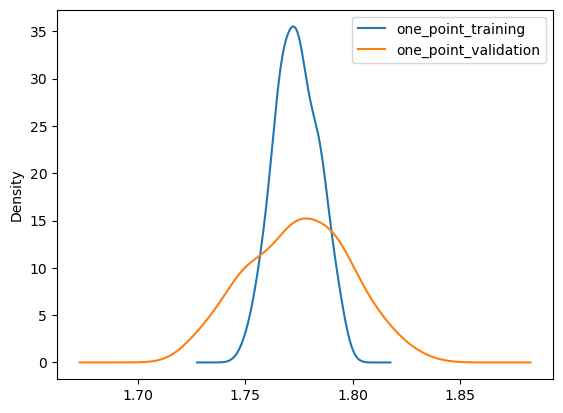

In [8]:
one_point_smape_scores_df = smape_scores_df[['one_point_training', 'one_point_validation']]
ax = one_point_smape_scores_df.plot.kde(xlabel = 'SMAPE')

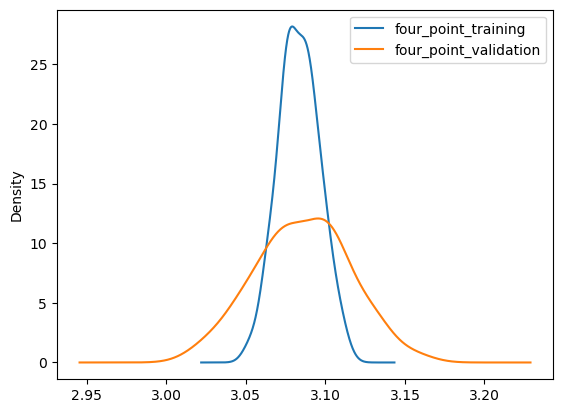

In [9]:
one_point_smape_scores_df = smape_scores_df[['four_point_training', 'four_point_validation']]
ax = one_point_smape_scores_df.plot.kde(xlabel = 'SMAPE')

OK - so cross validation SMAPE scores are quite a bit higher than the public leaderboard score using the same 'model'. I also notice that the four point SMAPE is much larger than the one point SMAPE. Will have to come back and look at this with fresh eyes to see if this is expected behavior or if there is a problem with my calculations. But it could just be that naive, 'carry-forward' predictions get worse the farther forward they are carried. 

Anyway that's the first pass at it complete.

**REVISIT**: Double checked sampling and scoring logic. Looks good, ran 100 fold cross validation. One point SMAPE is still much worse than the actual public leaderboard score for this model. Maybe November is just a really lucky test sample for this model - i.e. not much changed that month. Come to think of it, we could calculate how likely a SMAPE equal to or better than that observed on the leaderboard is using the mean and standard deviation from our cross validation experiment.

In [10]:
from statistics import NormalDist

one_point_training_mean = smape_scores_df['one_point_training'].describe()['mean']
one_point_training_std = smape_scores_df['one_point_training'].describe()['std']

print(f'Mean: {one_point_training_mean}')
print(f'Standard deviation: {one_point_training_std}')

leaderboard_score_probability = NormalDist(mu=one_point_training_mean, sigma=one_point_training_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability}')

Mean: 1.7738125460403156
Standard deviation: 0.010005429092449069
Probability of SMAPE <= 1.0936: 0.0


Yikes - this is kind of bad news. It means that either we are doing something wrong in our sampling & SMAPE calculations and inflating our SMAPE values, or the current public leaderboard is being scored against a very 'weird' (and easy for the naive model) sample. Let's try one more thing and repeat this experiment with a small sample size. Reasoning here is on the public leaderboard each county gets scored once (3,135 data points) whereas our training samples are around 70,000 points each. Seems more likely to get extreme values in small samples.

In [11]:
# Choose training fraction to result in ~3135 datapoints
training_fraction = 0.03135

# Fire up the pool
pool, result_objects = data_funcs.start_multiprocessing_pool()

# Submit each fold to a different CPU thread
for fold in range(folds):

    result = pool.apply_async(data_funcs.parallel_crossvalidation_smape,
    args = (
        parsed_data,
        training_fraction
        )
    )

    result_objects.append(result)

# Get results and shut down pool
smape_scores_df = data_funcs.cleanup_multiprocessing_pool(pool, result_objects)

print()

Starting processes for 18 CPUs (available - 2)



In [12]:
smape_scores_df.describe()

,one_point_training,one_point_validation,four_point_training,four_point_validation
count,100.000000,100.000000,100.000000,100.000000
mean,1.776039,1.774086,3.083838,3.084016
std,0.084516,0.002735,0.109335,0.003539
min,1.589869,1.766245,2.818449,3.072743
25%,1.731435,1.772301,3.007826,3.081947
50%,1.777253,1.774047,3.083038,3.084041
75%,1.831182,1.775530,3.147744,3.086476
max,2.018315,1.780111,3.432138,3.092605


Note the difference in standard deviation between training (small) and validation (large) samples!

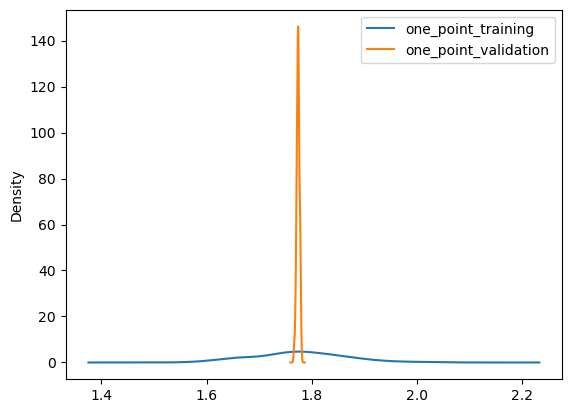

In [13]:
smape_scores_df = smape_scores_df[['one_point_training', 'one_point_validation']]
ax = smape_scores_df.plot.kde(xlabel = 'SMAPE')

In [14]:
training_mean = smape_scores_df['one_point_training'].describe()['mean']
training_std = smape_scores_df['one_point_training'].describe()['std']

print(f'Mean: {training_mean}')
print(f'Standard deviation: {training_std}')

leaderboard_score_probability = NormalDist(mu=training_mean, sigma=training_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability}')

Mean: 1.776038690973666
Standard deviation: 0.08451610194882292
Probability of SMAPE <= 1.0936: 3.3306690738754696e-16


It's still a vanishingly small probability of getting a sample from the training data on which the naive, 'carry-forward' model does as well or better on that it does on the current leaderboard test set. This makes things a bit difficult - i.e. we can't put much stock in our leaderboard score! Other forecasting methods might do better. But, I worry that if the leaderboard test set is so different from the rest of the dataset we will hurt our generalizability chasing a good public leaderboard score. If we tune everything to do as well as possible on the public leaderboard test set, we might get destroyed on the private leaderboard when new data shows up. Good news is, the public leaderboard test data for November data should be published soon.

**REVISIT** OK, I thought about this some more and I have an idea about what is going on here. Two points to remember 1) the dataset has some serious anomalies - i.e. dates where many/all counties experience uncharacteristically large changes in MBD. And 2) The timepoints are not really independent across counties. Just thinking about it, every county is subject to at least some of the same external forces, examples: covid, fed interest rates, stock market trends, national news etc.

With those two points in mind, let's assume that November 2022 (the timepoint used for scoring on the public leaderboard) is not an anomaly. Then think about how we are sampling our data blocks. We are taking a shotgun approach and grabbing a bunch of random time points for the training-validation split and likely including some anomalous timepoints. This inflates the sample SMAPE relative to the leaderboard SMAPE. Rather than scoring one timepoint and doing terribly if it's and anomaly and OK if it's not, we are taking some anomalous points and some nonanomalous points and as a result doing somewhat terribly every time. As a quick kludge experiment, let's try drawing only one timepoint for training and one timepoint for validation from each fold. We will also up the number of folds so that in the end, we are scoring the same total number of datapoints as before - i.e. scoring one datapoint 3135 * 100 times rather than averaging the score for 3135 datapoints 100 times. I expect we will get some very good results and some very bad results, with our observed leaderboard score being much less unlikely.

In [15]:
scored_timepoints = 1
folds *= 3135

In [16]:
%%time

# Fire up the pool
pool, result_objects = data_funcs.start_multiprocessing_pool()

# Submit each fold to a different CPU thread
for fold in range(folds):

    result = pool.apply_async(data_funcs.parallel_crossvalidation_smape_2,
    args = (
        parsed_data,
        training_fraction,
        scored_timepoints
        )
    )

    result_objects.append(result)

# Get results and shut down pool
smape_scores_df = data_funcs.cleanup_multiprocessing_pool(pool, result_objects)

print()

Starting processes for 18 CPUs (available - 2)

CPU times: user 1h 32min 53s, sys: 1h 49min 49s, total: 3h 22min 42s
Wall time: 11h 3min 14s


In [20]:
smape_scores_df.describe()

,one_point_training,one_point_validation,four_point_training,four_point_validation
count,313500.000000,313500.000000,313500.000000,313500.000000
mean,1.777476,0.026589,3.092194,1.421220
std,4.579346,0.152242,5.838560,0.012779
min,0.000000,0.000000,0.000000,1.372535
25%,0.319243,0.000000,0.923098,1.419457
50%,0.856207,0.000000,1.719196,1.419457
75%,1.869154,0.000000,3.252018,1.419457
max,200.000000,2.256245,200.000000,3.142305


In [22]:
one_point_training_mean = smape_scores_df['one_point_training'].describe()['mean']
one_point_training_std = smape_scores_df['one_point_training'].describe()['std']

print(f'Mean: {one_point_training_mean}')
print(f'Standard deviation: {one_point_training_std}')

leaderboard_score_probability = NormalDist(mu=one_point_training_mean, sigma=one_point_training_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability}')

Mean: 1.7774764535982694
Standard deviation: 4.579346225171415
Probability of SMAPE <= 1.0936: 0.4406429449327816


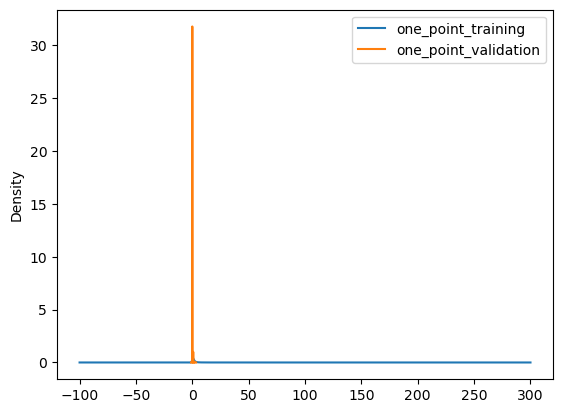

In [19]:
one_point_smape_scores_df = smape_scores_df[['one_point_training', 'one_point_validation']]
ax = one_point_smape_scores_df.plot.kde(xlabel = 'SMAPE')

OK - completely different results. As expected, we have some very good scores and some very bad scores relative to our leaderboard score, which now does not look unlikely at all. What did we learn? When scoring predictions, don't aggregate across multiple forecast origins. I would call this done, but looking at the result closely, we seem to have uncovered or caused a new problem. Even with a 50:50 training:validation split, the training scores have a higher mean and larger spread. Not immediately sure why that should be the case. Seems like bug, we should definitely fix/explain it before moving on...

<a name="TODO"></a>
### 5. TODO
1. <s>Check cross validation parsing for frameshift/indexing errors.</s>
2. Refactor SMAPE scoring function to take the number of timepoints to score from the training and test samples as an argument. Set sensible defaults.
3. Refactor helper functions into module.
4. <s>Parallelize sampling over processors using python multiprocessing module.</s>